# Decomposer Test

This notebook is made for assessing the performence of the decomposer alone

## Generate QD

In [ ]:
from transformers.models.auto.tokenization_auto import AutoTokenizer
from transformers import AutoModelForCausalLM
from datasets import load_dataset
from tqdm import tqdm

from src.prompters import PrompterRegistry
from src.utils.generation import to_model_prompt, generate_batch
from src.experiments.qpl.text_to_qpl import get_decomposer_generation_params, DecomposerMode
import src.utils.paths as p

# Constants
BATCH_SIZE = 8
MAX_NEW_TOKENS = 8192
MODEL_DIR = "jaqv74z8_Qwen3-4B-qpl-decomposer-cot-ds_train_batch_size=1_gradient_accumulation_steps=8_learning_rate=0.0002_num_train_epochs=4_gradient_checkpointing=True_logging_steps=0.00125_save_steps=0.0625_random_seed=1_lora=True_r=16_alpha=32_dropout=0.05"
MODEL_CKPT = MODEL_DIR + "/checkpoint-3616"
MODEL_PATH = p.TRAINED_MODELS_DIR / MODEL_CKPT
# DATASET_ID = "bgunlp/question_decomposer_ds"
DATASET_ID = "d4nieldev/qpl-decomposer-cot-ds"
MAX_RETRIES = 3
MODE = DecomposerMode.SAMPLING


# Load model & tokenizer
model = AutoModelForCausalLM.from_pretrained(MODEL_PATH).cuda()
model = model.eval()
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

# Load and process data
test_dataset = list(load_dataset(DATASET_ID, split="validation"))
prompter = PrompterRegistry.get(DATASET_ID)(with_assistant=False)
chat_templates = list(map(prompter.to_chat_template, test_dataset))
prompts = list(map(lambda ct: to_model_prompt(tokenizer, ct), chat_templates))

# Decompose questions
predictions = generate_batch(
    model=model,
    tokenizer=tokenizer,
    model_prompts=prompts,
    batch_size=BATCH_SIZE,
    max_new_tokens=MAX_NEW_TOKENS,
    progress_bar=tqdm(total=len(prompts), desc="Decomposing"),
    max_retries=MAX_RETRIES,
    **get_decomposer_generation_params(MODE)
)

/home/danieloh/.conda/envs/qpl/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Decomposing: 100%|██████████| 3043/3043 [2:47:39<00:00,  3.31s/it]  


## Evaluate

[2025-07-20 19:06:54] INFO - sentence_transformers.SentenceTransformer - Use pytorch device_name: cuda:0
[2025-07-20 19:06:54] INFO - sentence_transformers.SentenceTransformer - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
[2025-07-20 19:07:01] WARNING - root - No valid parent found for question: Find the id and country of all tv channels.
[2025-07-20 19:07:01] WARNING - root - No valid parent found for question: Find the different countries and the number of tv channels from each.
[2025-07-20 19:07:01] WARNING - root - No valid parent found for question: Find the countries where have more than two tv channels.
[2025-07-20 19:07:01] WARNING - root - No valid parent found for question: find id of the tv channels that from the countries where have more than two tv channels.
[2025-07-20 19:07:01] WARNING - root - No valid parent found for question: What is the number of TV channels in each country?
[2025-07-20 19:07:01] WARNING - root - No valid parent found

Operator Accuracy: 0.9099572790009859
Sentence Similarity (when operator is correct): 0.4448360204696655
              precision    recall  f1-score  support
aggregate      0.927757  0.888889  0.907907      549
except         0.904110  0.857143  0.880000       77
filter         0.950000  0.791667  0.863636       96
intersect      0.725000  0.828571  0.773333       35
join           0.730561  0.854123  0.787524      473
scan           0.971504  0.935546  0.953186     1567
sort           0.981132  1.000000  0.990476       52
topsort        0.937500  0.978261  0.957447      184
union          0.470588  0.800000  0.592593       10
accuracy       0.909957  0.909957  0.909957        0
macro avg      0.844239  0.881578  0.856234     3043
weighted avg   0.917403  0.909957  0.912231     3043


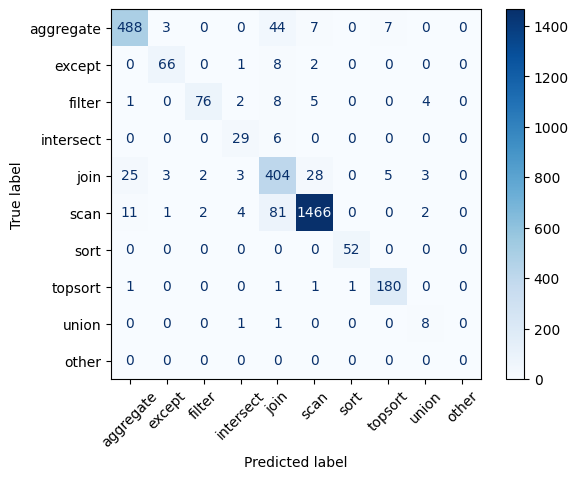

In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report

op_correct = 0
sum_similarity = 0
sentences_count = 0

op_to_id = {
    'aggregate': 0,
    'except': 1,
    'filter': 2,
    'intersect': 3,
    'join': 4,
    'scan': 5,
    'sort': 6,
    'topsort': 7,
    'union': 8,
    'other': 9
}
id_to_op = {v: k for k, v in op_to_id.items()}

emb_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

y_pred = []
y_true = []

prompter = PrompterRegistry.get(DATASET_ID)(with_assistant=True)
chat_templates = []
for example in test_dataset:
    chat_templates.append(prompter.to_chat_template(example))

output_pattern = re.compile(r"(?P<reasoning><think>.*?</think>)?\s*(?P<answer>.*)", re.DOTALL)

output_json = []
for pred, chat_template in tqdm(zip(predictions, chat_templates), desc="Evaluating", total=len(predictions)):
    if pred is None:
        print("No prediction for chat template:", chat_template)
        continue

    # save prediction vs. gold
    output_json.append({
        "input": [ct for ct in chat_template['messages'] if ct['role'] in ['system', 'user']],
        "pred": pred,
        "gold": chat_template['messages'][-1]['content']
    })

    # process data
    gold = chat_template['messages'][-1]['content']
    if not (gold_match := output_pattern.match(gold)):
        raise ValueError(f"Invalid gold output format: {gold}")
    if not (pred_match := output_pattern.match(pred)):
        print(f"Invalid prediction format:\n\n{pred}\n\n---------------------------")
        continue

    pred_lines = pred_match.group("answer").split("\n")
    gold_lines = gold_match.group("answer").split("\n")

    # operator classification
    pred_op_id = op_to_id.get(pred_lines[0].lower(), op_to_id["other"])
    gold_op_id = op_to_id.get(gold_lines[0].lower(), op_to_id["other"])
    y_pred.append(pred_op_id)
    y_true.append(gold_op_id)

    # sentence similarity
    if pred_op_id == gold_op_id:
        op_correct += 1

        model_sentences = pred_lines[1:]
        label_sentences = gold_lines[1:]

        sentences_count += len(label_sentences)

        if len(model_sentences) != len(label_sentences):
            print("======================")
            print(pred)
            print("----")
            print(gold)
            print("======================")
        else:
            all_sentences = model_sentences + label_sentences
            embeddings = emb_model.encode(all_sentences, show_progress_bar=False)
            similarity_matrix = embeddings @ embeddings.T
            if len(model_sentences) == 0:
                similarity = 0
            elif len(model_sentences) == 1:
                similarity = similarity_matrix[0][1]
            else:
                similarity = max(
                    similarity_matrix[0,2] + similarity_matrix[1,3],
                    similarity_matrix[0,3] + similarity_matrix[1,2]
                ) / 2
            sum_similarity += similarity

print(f"Operator Accuracy: {op_correct / len(test_dataset)}")
print(f"Sentence Similarity (when operator is correct): {sum_similarity / op_correct}")

# Generate a classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Print nicely
df = pd.DataFrame(report).transpose()
df.index = df.index.map(lambda x: id_to_op[int(x)] if x.isdigit() else x)
df['support'] = df['support'].astype(int)
print(df)

cm = confusion_matrix(y_true, y_pred, labels=list(op_to_id.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(op_to_id.keys()))
disp.plot(cmap=plt.cm.Blues)

plt.xticks(rotation=45)
plt.show()

In [3]:
import json
with open('output/qpl/decomposer_3_predictions.json', 'w') as f:
    json.dump(output_json, f, indent=2)